# Travel Insurance

Created By: Pratiwi Astuti

## Business Problem Understanding

**Context** <br>
Perusahaan travel menawarkan paket asuransi kepada customernya. Perusahaan ingin tahu customer mana yang dapat meng-claim asuransi sesuai dengan history yang ada pada database. <br>
Asuransi diberikan kepada customer yang memenuhi kriteria perusahaan berdasarkan data yang sudah ada. Dalam hal ini kita akan membuat model untuk memprediksi customer mana yang lolos claim asuransinya.

**Target** <br>
0 : Claim accepted <br>
1 : Claim declined

**Problem Statement**<br>
Proses pemilihan customer yang dapat menerima claim asurasi akan memakan waktu jika perusahaan tidak melakukan penyaringan terlebih dahulu. Oleh karena itu, perusahaan ingin meningkatkan efisiensi pemilihan dengan mengetahui kriteria customer mana saja yang dapat atau berhak menerima asuransi.

**Goals** <br>
Berdasarkan permasalahan yang ada, perusahaan ingin memiliki kemampuan untuk memprediksi customer yang dapat menerima/meng-klaim asuransi atau tidak dapat meng-klaim asuransi dari kriteria pada dataset yang ada.

**Analytic Approach**<br>
Jadi yang akan kita lakukan adalah menganalisa data untuk menemukan pola yang membedakan kandidat yang adapat meng-claim asuransi dengan yang tidak dapat meng-claim asuransi.<br>
Selanjutnya kita akan membangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas seorang kandidat customer yang dapat menerima atau tidak asuransi.

**Metric Evaluation** <br>
Type 1 error : False Negative  <br>
FN, yaitu banyaknya prediksi kelas negatif yang pada kenyataanya masuk ke dalam kelas positif. <br>
Konsekuensi: kehilangan kepercayaan customer 

Type 2 error : False Positive  <br>
FP, yaitu banyaknya prediksi kelas positif yang sebenarnya masuk ke dalam kelas negatif. <br>
Konsekuensi: sia-sianya biaya pencairan claim, waktu dan sumber daya

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mengurangi cost dan waktu pengklaiman asuransi dari perusahaan tersebut, tetapi tanpa membuat menjadi kurangnya/tidak cukup kandidat customer yang seharusnya menerima claim asuransi perusahaan. Jadi harus kita seimbangkan nanti antara precision dan recallnya dari kelas positive (kandidat potensial). Jadi nanti metric utama yang akan kita gunakan adalah roc_auc.

## Data Understanding

Dataset source: https://www.kaggle.com/datasets/mhdzahier/travel-insurance 


Note:
- Dataset tidak seimbang (imbalance)
- Sebagian besar fitur bersifat kategorik

### Atribute Information

| Attribute | Data Type, Length | Description |
| --- | --- | --- |
| Agency | Text | Name of agency |
| Agency Type | Text | Type of travel insurance agencies |
| Distribution Channel | Text | Distribution channel of travel insurance agencies |
| Product Name | Text | Name of the travel insurance products |
| Gender | Text | Gender of insured |
| Duration | Long | Duration of travel |
| Destination | Text | Destination of travel |
| Net Sales | Float | Amount of sales of travel insurance policies |
| Commision (in value) | Float | Commission received for travel insurance agency |
| Age | Long | Age of insured |
| Claim | Float | Claim status (0 : `not approved` dan 1 : `approved`) |

In [615]:
# Library
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, auc
from sklearn.feature_selection import SelectKBest, chi2

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Scipy
import scipy.stats as ss
from scipy.stats import chi2_contingency

# Counter
from collections import Counter

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)


In [616]:
df = pd.read_csv('data_travel_insurance.csv', na_values=['?', 'NA', 'NAN'])
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


## Exploratory Data Analysis

##### Check typo, data type, dan missing value

In [617]:
df_new = df.copy()
df_new.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


Dari data diatas diketahui bahwa pada nama kolom terdapat spasi, dalam hal ini akan kita ubah spasi menjadi **_** agar menghindari kesalahan pengetikan.

In [618]:
df_new.rename(columns= {'Agency Type':'Agency_Type', 
                       'Distribution Channel':'Distribution_Channel',
                       'Product Name':'Product_Name',
                       'Net Sales':'Net_Sales', 
                       'Commision (in value)':'Commision'},
                       inplace=True)

In [619]:
df_new.head()

,Agency,Agency_Type,Distribution_Channel,Product_Name,Gender,Duration,Destination,Net_Sales,Commision,Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


In [620]:
listItem = []
for col in df_new.columns :
    listItem.append([col, df_new[col].dtype, df_new[col].isna().sum(), round((df_new[col].isna().sum()/len(df_new[col])) * 100,2),
                    df_new[col].nunique(), list(df_new[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Agency,object,0,0.00,16,"[TTW, RAB]"
1,Agency_Type,object,0,0.00,2,"[Travel Agency, Airlines]"
2,Distribution_Channel,object,0,0.00,2,"[Offline, Online]"
3,Product_Name,object,0,0.00,26,"[Cancellation Plan, Rental Vehicle Excess Insu..."
4,Gender,object,31647,71.39,2,"[M, F]"
5,Duration,int64,0,0.00,437,"[437, 90]"
6,Destination,object,0,0.00,138,"[OMAN, AZERBAIJAN]"
7,Net_Sales,float64,0,0.00,1006,"[-207.9, 9.33]"
8,Commision,float64,0,0.00,915,"[2.17, 2.81]"
9,Age,int64,0,0.00,89,"[62, 21]"


In [621]:
print(df_new.info())
print(' ')
print(df_new.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency_Type           44328 non-null  object 
 2   Distribution_Channel  44328 non-null  object 
 3   Product_Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net_Sales             44328 non-null  float64
 8   Commision             44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB
None
 
(44328, 11)


**Gender**

Dari informasi diatas diketahui bahwa hanya column `Gender` yang memiliki missing value dan jumlahnya sebesar 71.39%. Missing value ini akan di handle dengan cara di *drop* mengingat kita tidak bisa mengisi column ini dengan metode yang ada. Selain itu, column ini juga tidak memiliki informasi yang penting untuk proses analysis selanjutnya.

In [622]:
df_new['Gender'].isnull().sum()

31647

In [623]:
# Drop column Gender

df_new.drop(columns= ['Gender'], inplace= True)

In [624]:
df_new.isnull().sum()

Agency                  0
Agency_Type             0
Distribution_Channel    0
Product_Name            0
Duration                0
Destination             0
Net_Sales               0
Commision               0
Age                     0
Claim                   0
dtype: int64

In [625]:
df_new.head()

,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision,Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.0,28,No


**Claim**

Kita akan cek data pada kolom `Claim`, yang mana pada kolom ini akan kita jadikan target. Data pada kolom ini berisi **Yes** dan **No**.

In [626]:
# Cek data Claim pada dataset

print('Claim (Yes): ', df_new[df_new["Claim"] == 'Yes']["Claim"].count())
print('Claim (No): ', df_new[df_new["Claim"] == 'No']["Claim"].count())

Claim (Yes):  677
Claim (No):  43651


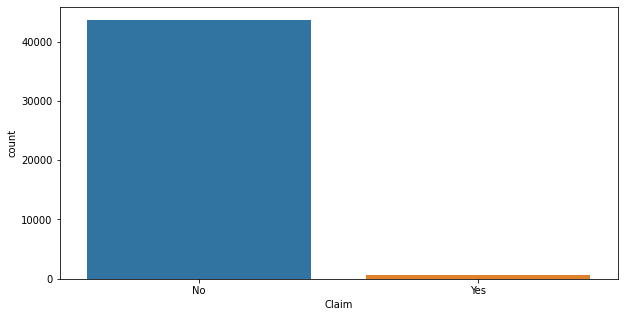

In [627]:
plt.figure(figsize = (10,5))
sns.countplot(df_new['Claim'])
plt.show()

Dari hasil pengecekan dan visualisasi diatas diketahui bahwa ada imbalance pada data Claim (target).

**Duration**

In [628]:
df_new['Duration'].unique()

array([ 365,    4,   19,   20,    8,    2,   25,   90,   24,   43,  103,
        376,    6,   16,   27,   34,    3,   14,   12,   31,    5,    7,
         56,   29,   30,   58,    9,   38,   42,   11,   13,   40,   79,
        370,  366,   26,   83,   55,   18,  100,    1,   35,   36,   75,
         23,   73,   32,  232,   37,   10, 4736,   15,   17,   99,  173,
         74,   82,   66,  156,   39,   95,   98,  111,  430,   53,   77,
         87,   70,  151,   45,   54,  114,  118,   62,   28,  112,  326,
         22,   59,   44,   21,   97,   63,   60,   51,  180,  160,  368,
         65,   93,   71,   57,    0,   76,   69,  110,  146,  116,  129,
         84,   33,  149,   68,   64,  101,  145,   88,  222,  176,  165,
        169,  387,   49,  109,   41,  381,   50,  161,  154,  330,   46,
         78,   47,  121,  106,  140,   91,  104,  134,  393,  282,  123,
        172,   86,  102,  314,  386,  383,   81,  283,  115,  144,   61,
        206,  213,  271,  174,  152,  122,   94,  2

In [629]:
df_new[df_new['Duration'] < 0]

,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision,Age,Claim
26228,JZI,Airlines,Online,Basic Plan,-1,MALAYSIA,18.0,6.3,118,No
26494,JZI,Airlines,Online,Basic Plan,-1,BRUNEI DARUSSALAM,18.0,6.3,118,No


In [630]:
data_duration = df_new[((df_new['Product_Name'] == 'Basic Plan') & (df_new['Destination'] == 'MALAYSIA'))]
data_duration

,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision,Age,Claim
157,JZI,Airlines,Online,Basic Plan,28,MALAYSIA,30.0,10.50,33,No
185,JZI,Airlines,Online,Basic Plan,7,MALAYSIA,18.0,6.30,53,No
651,JZI,Airlines,Online,Basic Plan,6,MALAYSIA,22.0,7.70,41,No
676,JZI,Airlines,Online,Basic Plan,17,MALAYSIA,22.0,7.70,23,No
769,JZI,Airlines,Online,Basic Plan,6,MALAYSIA,18.0,6.30,58,No
...,...,...,...,...,...,...,...,...,...,...
43844,JZI,Airlines,Online,Basic Plan,30,MALAYSIA,22.0,7.70,38,No
43951,JZI,Airlines,Online,Basic Plan,51,MALAYSIA,22.0,7.70,56,No
44001,JZI,Airlines,Online,Basic Plan,14,MALAYSIA,33.0,11.55,45,No
44021,JZI,Airlines,Online,Basic Plan,1,MALAYSIA,18.0,6.30,45,No


Dari pengecekan diatas diketahui bahwa ada 2 data yang memiliki nilai Duration -1. Ini merupakan data yang salah mengingat tidak ada durasi dalam nilai minus. Oleh karena itu data yang bernilai -1 akan diubah menjadi 1. Hal ini sudah dibandingkan juga dengan data yang memiliki nilai Duration 1.

In [631]:
df_new.describe()

,Duration,Net_Sales,Commision,Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


In [632]:
df_new.dtypes

Agency                   object
Agency_Type              object
Distribution_Channel     object
Product_Name             object
Duration                  int64
Destination              object
Net_Sales               float64
Commision               float64
Age                       int64
Claim                    object
dtype: object

In [633]:
# ubah data pada kolom Duration dari -1 menjadi 1

df_new.loc[df_new['Duration'] == -1, 'Duration'] = 1

In [634]:
# Cek untuk nilai -1 apakah masih ada atau tidak?

df_new.describe()

,Duration,Net_Sales,Commision,Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424382,40.550948,9.707692,39.925600
std,109.153920,48.661970,19.625637,13.954926
min,0.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


In [635]:
# Cek data Duration untuk nilai negatif, apakah masih ada?

df_new[df_new['Duration'] < 0]

,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision,Age,Claim


**Commision dan Net_Sales**

In [636]:
df_new.describe()

,Duration,Net_Sales,Commision,Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424382,40.550948,9.707692,39.925600
std,109.153920,48.661970,19.625637,13.954926
min,0.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


Dari info diatas diketahui bahwa ada data yang bernilai *negatif* pada kolom `Net_Sales`. Dalam hal ini kita akan handle dengan drop data yang bernilai negatif dikarenakan net sales tidak mungkin bernilai negatif.

In [637]:
# Cek data bernilai negatif pada kolom Net_Sales

df_new[df_new['Net_Sales'] < 0]

,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision,Age,Claim
94,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,-216.75,54.19,36,No
116,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,430,AUSTRALIA,-59.40,35.64,41,No
121,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,77,JAPAN,-29.70,17.82,59,No
199,EPX,Travel Agency,Online,Cancellation Plan,29,HONG KONG,-12.00,0.00,36,No
241,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,57,AUSTRALIA,-59.40,35.64,28,No
...,...,...,...,...,...,...,...,...,...,...
43694,EPX,Travel Agency,Online,2 way Comprehensive Plan,140,UNITED STATES,-98.00,0.00,29,No
43743,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,23,MALAYSIA,-29.70,17.82,29,No
43751,EPX,Travel Agency,Online,2 way Comprehensive Plan,147,SPAIN,-68.00,0.00,36,No
43858,EPX,Travel Agency,Online,Cancellation Plan,49,UNITED KINGDOM,-68.00,0.00,36,No


In [638]:
df_new['Net_Sales'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 44328 entries, 0 to 44327
Series name: Net_Sales
Non-Null Count  Dtype  
--------------  -----  
44328 non-null  float64
dtypes: float64(1)
memory usage: 346.4 KB


In [639]:
df_new[df_new['Net_Sales'] < 0].value_counts().sum()

483

In [640]:
# Cek data bernilai negatif pada kolom kemudian diubah menjadi NaN

df_new[df_new['Net_Sales'] < 0] = None

In [641]:
df_new['Net_Sales'].isnull().sum()

483

In [642]:
# Drop data NaN (sebelumnya data yang bernilai negatif pada kolom Net Sales)

df_new.dropna(subset= ['Net_Sales'], inplace= True)

In [643]:
df_new[df_new['Net_Sales'] < 0]

,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision,Age,Claim


In [644]:
df_new['Net_Sales'].isnull().sum()

0

Selanjutnya mengecek hubungan antara kolom `Net_Sales` dan `Commision`

In [645]:
df_new.corr()

,Duration,Net_Sales,Commision,Age
Duration,1.000000,0.416278,0.315394,0.005248
Net_Sales,0.416278,1.000000,0.704986,0.040870
Commision,0.315394,0.704986,1.000000,0.120230
Age,0.005248,0.040870,0.120230,1.000000


In [646]:
# Cek data yang memiliki Net Sales < Commision in value

df_new[df_new['Net_Sales'] < df_new['Commision']]

,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision,Age,Claim
45,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,24.0,UNITED ARAB EMIRATES,0.0,23.76,27.0,No
60,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,14.0,AUSTRALIA,0.0,17.82,31.0,No
75,C2B,Airlines,Online,Silver Plan,23.0,SINGAPORE,0.0,5.63,25.0,No
125,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,95.0,NETHERLANDS,0.0,5.94,31.0,No
201,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,5.0,MALAYSIA,0.0,23.76,41.0,No
...,...,...,...,...,...,...,...,...,...,...
44168,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,13.0,CANADA,0.0,41.58,31.0,No
44187,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,5.0,MALAYSIA,0.0,17.82,31.0,No
44213,CCR,Travel Agency,Offline,Comprehensive Plan,56.0,THAILAND,0.0,9.57,20.0,No
44268,JZI,Airlines,Online,Basic Plan,8.0,HONG KONG,0.0,12.25,69.0,No


In [647]:
df_new[df_new['Net_Sales'] == df_new['Commision']]

,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision,Age,Claim
63,EPX,Travel Agency,Online,Cancellation Plan,100.0,UNITED STATES,0.0,0.0,37.0,No
78,EPX,Travel Agency,Online,Cancellation Plan,73.0,BELGIUM,0.0,0.0,36.0,No
118,EPX,Travel Agency,Online,Cancellation Plan,13.0,CHINA,0.0,0.0,35.0,No
470,EPX,Travel Agency,Online,Cancellation Plan,14.0,JAPAN,0.0,0.0,27.0,No
545,EPX,Travel Agency,Online,Cancellation Plan,7.0,SINGAPORE,0.0,0.0,37.0,No
...,...,...,...,...,...,...,...,...,...,...
43907,EPX,Travel Agency,Online,2 way Comprehensive Plan,9.0,MALAYSIA,0.0,0.0,57.0,No
44084,EPX,Travel Agency,Online,Cancellation Plan,7.0,CHINA,0.0,0.0,36.0,No
44159,EPX,Travel Agency,Online,Cancellation Plan,58.0,CANADA,0.0,0.0,34.0,No
44207,EPX,Travel Agency,Online,2 way Comprehensive Plan,152.0,UNITED STATES,0.0,0.0,49.0,No


Dari data diatas diketahui bahwa ada data yang memiliki nilai komisi (pada table `Commision`) lebih besar dari nilai penjualan (pada table `Net_Sales`) dan ini merupakan hal yang tidak mungkin. Oleh karena itu kita dapat mengatasinya dengan membuat nilai komisi menjadi **nol**. 

In [648]:
df_new[df_new['Commision'] == 0]

,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision,Age,Claim
1,EPX,Travel Agency,Online,Cancellation Plan,4.0,MALAYSIA,10.0,0.0,33.0,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20.0,UNITED STATES,112.0,0.0,59.0,No
5,EPX,Travel Agency,Online,Cancellation Plan,2.0,SINGAPORE,10.0,0.0,36.0,No
6,EPX,Travel Agency,Online,1 way Comprehensive Plan,25.0,"KOREA, REPUBLIC OF",50.0,0.0,36.0,No
7,EPX,Travel Agency,Online,Cancellation Plan,90.0,SINGAPORE,78.0,0.0,22.0,No
...,...,...,...,...,...,...,...,...,...,...
44320,EPX,Travel Agency,Online,2 way Comprehensive Plan,7.0,VIET NAM,34.0,0.0,36.0,No
44321,EPX,Travel Agency,Online,Cancellation Plan,4.0,ITALY,10.0,0.0,36.0,No
44322,EPX,Travel Agency,Online,2 way Comprehensive Plan,6.0,THAILAND,40.0,0.0,36.0,No
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,14.0,CHINA,30.0,0.0,36.0,Yes


In [649]:
df_new[['Net_Sales', 'Commision']].dtypes

Net_Sales    float64
Commision    float64
dtype: object

In [650]:
df_new.describe()

,Duration,Net_Sales,Commision,Age
count,43845.000000,43845.000000,43845.000000,43845.000000
mean,49.109066,41.659214,9.551165,39.924393
std,109.415244,47.463986,19.483377,13.941949
min,0.000000,0.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,27.000000,0.000000,36.000000
75%,52.000000,49.000000,10.640000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


In [651]:
df_new[df_new['Net_Sales'] == 0]

,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision,Age,Claim
45,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,24.0,UNITED ARAB EMIRATES,0.0,23.76,27.0,No
60,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,14.0,AUSTRALIA,0.0,17.82,31.0,No
63,EPX,Travel Agency,Online,Cancellation Plan,100.0,UNITED STATES,0.0,0.00,37.0,No
75,C2B,Airlines,Online,Silver Plan,23.0,SINGAPORE,0.0,5.63,25.0,No
78,EPX,Travel Agency,Online,Cancellation Plan,73.0,BELGIUM,0.0,0.00,36.0,No
...,...,...,...,...,...,...,...,...,...,...
44207,EPX,Travel Agency,Online,2 way Comprehensive Plan,152.0,UNITED STATES,0.0,0.00,49.0,No
44213,CCR,Travel Agency,Offline,Comprehensive Plan,56.0,THAILAND,0.0,9.57,20.0,No
44268,JZI,Airlines,Online,Basic Plan,8.0,HONG KONG,0.0,12.25,69.0,No
44273,EPX,Travel Agency,Online,Cancellation Plan,52.0,PHILIPPINES,0.0,0.00,36.0,No


In [652]:
# Ubah data commision menjadi 0

df_new.loc[df_new['Net_Sales'] == 0, 'Commision'] = 0

In [653]:
# Cek ulang data yang sudah diubah

df_new[df_new['Net_Sales'] < df_new['Commision']]

,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision,Age,Claim


**Check data duplicate**

In [654]:
df_new.duplicated().sum()

5029

Dari info diatas diketahui bahwa ada 5029 data duplicate, kita akan drop data duplicate tersebut.


In [655]:
df_new = df_new.drop_duplicates(keep= 'first')

In [656]:
df_new.duplicated().sum()

0

In [657]:
df_new.isnull().sum()

Agency                  0
Agency_Type             0
Distribution_Channel    0
Product_Name            0
Duration                0
Destination             0
Net_Sales               0
Commision               0
Age                     0
Claim                   0
dtype: int64

In [658]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38816 entries, 0 to 44327
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                38816 non-null  object 
 1   Agency_Type           38816 non-null  object 
 2   Distribution_Channel  38816 non-null  object 
 3   Product_Name          38816 non-null  object 
 4   Duration              38816 non-null  float64
 5   Destination           38816 non-null  object 
 6   Net_Sales             38816 non-null  float64
 7   Commision             38816 non-null  float64
 8   Age                   38816 non-null  float64
 9   Claim                 38816 non-null  object 
dtypes: float64(4), object(6)
memory usage: 3.3+ MB


### Data yang sudah bersih

Setelah kita melakukan EDA, saat ini kita 38816 baris dan 10 kolom.

In [659]:
listItem = []
for col in df_new.columns :
    listItem.append([col, df_new[col].dtype, df_new[col].isna().sum(), round((df_new[col].isna().sum()/len(df_new[col])) * 100,2),
                    df_new[col].nunique(), list(df_new[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Agency,object,0,0.0,16,"[CCR, CBH]"
1,Agency_Type,object,0,0.0,2,"[Travel Agency, Airlines]"
2,Distribution_Channel,object,0,0.0,2,"[Offline, Online]"
3,Product_Name,object,0,0.0,26,"[Comprehensive Plan, Gold Plan]"
4,Duration,float64,0,0.0,435,"[159.0, 5.0]"
5,Destination,object,0,0.0,137,"[LATVIA, MALAYSIA]"
6,Net_Sales,float64,0,0.0,886,"[202.0, 2.55]"
7,Commision,float64,0,0.0,905,"[72.94, 23.76]"
8,Age,float64,0,0.0,89,"[36.0, 29.0]"
9,Claim,object,0,0.0,2,"[Yes, No]"


In [660]:
df_new

,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision,Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365.0,SINGAPORE,216.0,54.00,57.0,No
1,EPX,Travel Agency,Online,Cancellation Plan,4.0,MALAYSIA,10.0,0.00,33.0,No
2,JZI,Airlines,Online,Basic Plan,19.0,INDIA,22.0,7.70,26.0,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20.0,UNITED STATES,112.0,0.00,59.0,No
4,C2B,Airlines,Online,Bronze Plan,8.0,SINGAPORE,16.0,4.00,28.0,No
...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,14.0,CHINA,30.0,0.00,36.0,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17.0,AUSTRALIA,79.2,47.52,47.0,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,64.0,THAILAND,30.0,10.50,50.0,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,51.0,CHINA,36.0,0.00,36.0,No


In [661]:
print(df_new.info())
print(' ')
print(df_new.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38816 entries, 0 to 44327
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                38816 non-null  object 
 1   Agency_Type           38816 non-null  object 
 2   Distribution_Channel  38816 non-null  object 
 3   Product_Name          38816 non-null  object 
 4   Duration              38816 non-null  float64
 5   Destination           38816 non-null  object 
 6   Net_Sales             38816 non-null  float64
 7   Commision             38816 non-null  float64
 8   Age                   38816 non-null  float64
 9   Claim                 38816 non-null  object 
dtypes: float64(4), object(6)
memory usage: 3.3+ MB
None
 
(38816, 10)


In [662]:
df_new.describe()

,Duration,Net_Sales,Commision,Age
count,38816.000000,38816.00000,38816.000000,38816.000000
mean,51.986165,43.49916,9.560297,39.833290
std,113.780561,48.35249,19.738704,13.197319
min,0.000000,0.00000,0.000000,0.000000
25%,11.000000,19.80000,0.000000,35.000000
50%,25.000000,29.00000,0.000000,36.000000
75%,56.000000,50.00000,10.500000,44.000000
max,4881.000000,810.00000,283.500000,118.000000


In [663]:
df_new.corr()

,Duration,Net_Sales,Commision,Age
Duration,1.000000,0.390539,0.295783,0.012907
Net_Sales,0.390539,1.000000,0.744188,0.042151
Commision,0.295783,0.744188,1.000000,0.121794
Age,0.012907,0.042151,0.121794,1.000000


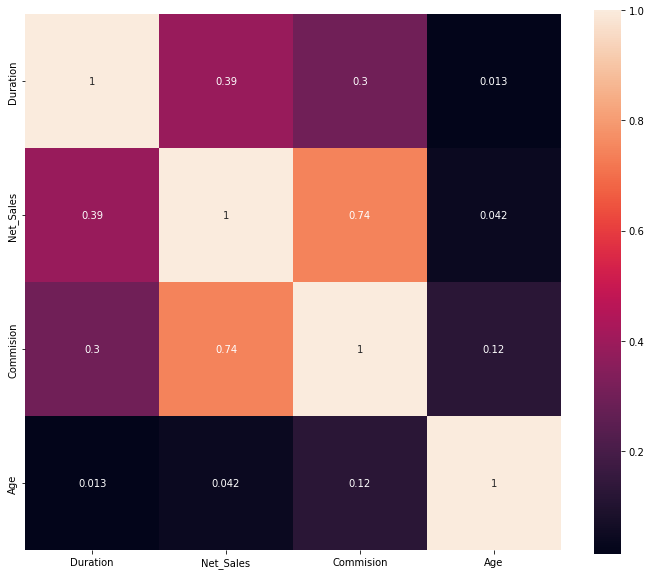

In [664]:
# lihat korelasi

plt.figure(figsize = (12, 10))
sns.heatmap(df_new.corr(), square=True, annot=True)
plt.show()

### Data Analysis

##### Check descriptive analytics

In [665]:
df_new.describe()

,Duration,Net_Sales,Commision,Age
count,38816.000000,38816.00000,38816.000000,38816.000000
mean,51.986165,43.49916,9.560297,39.833290
std,113.780561,48.35249,19.738704,13.197319
min,0.000000,0.00000,0.000000,0.000000
25%,11.000000,19.80000,0.000000,35.000000
50%,25.000000,29.00000,0.000000,36.000000
75%,56.000000,50.00000,10.500000,44.000000
max,4881.000000,810.00000,283.500000,118.000000


##### Check distributions (variable numeric)

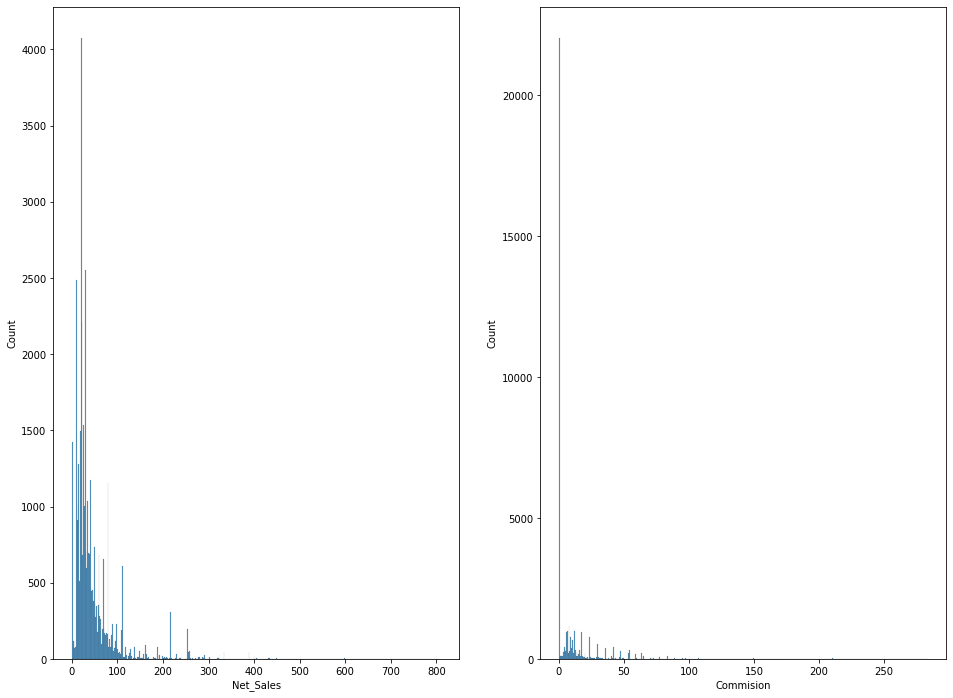

In [666]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12))

sns.histplot(df_new['Net_Sales'], ax=axes[0])
sns.histplot(df_new['Commision'], ax=axes[1])

plt.show()

In [667]:
df_new.dtypes

Agency                   object
Agency_Type              object
Distribution_Channel     object
Product_Name             object
Duration                float64
Destination              object
Net_Sales               float64
Commision               float64
Age                     float64
Claim                    object
dtype: object

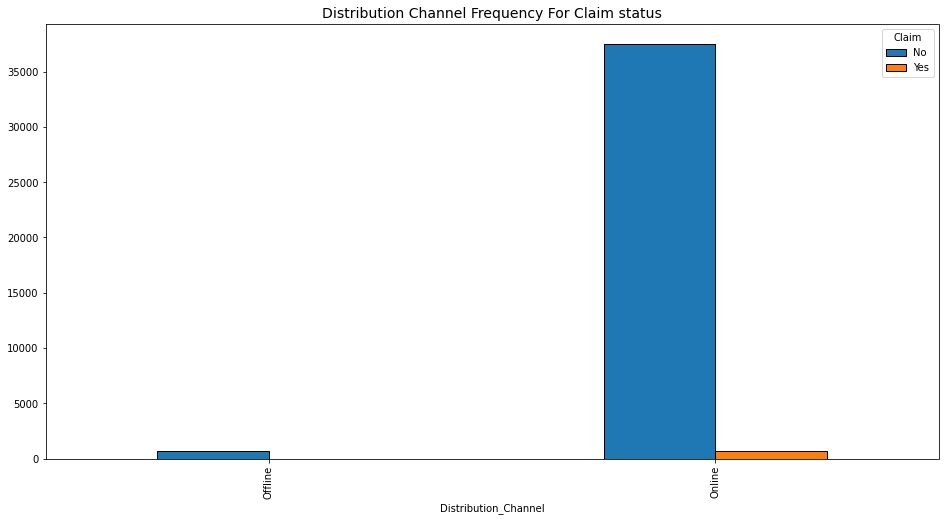

In [668]:
pd.crosstab(df_new['Distribution_Channel'], df_new['Claim']).plot(kind = 'bar', figsize = (16, 8), rot= 90, ec= 'black')
plt.title('Distribution Channel Frequency For Claim status', fontsize= 14)

plt.show()

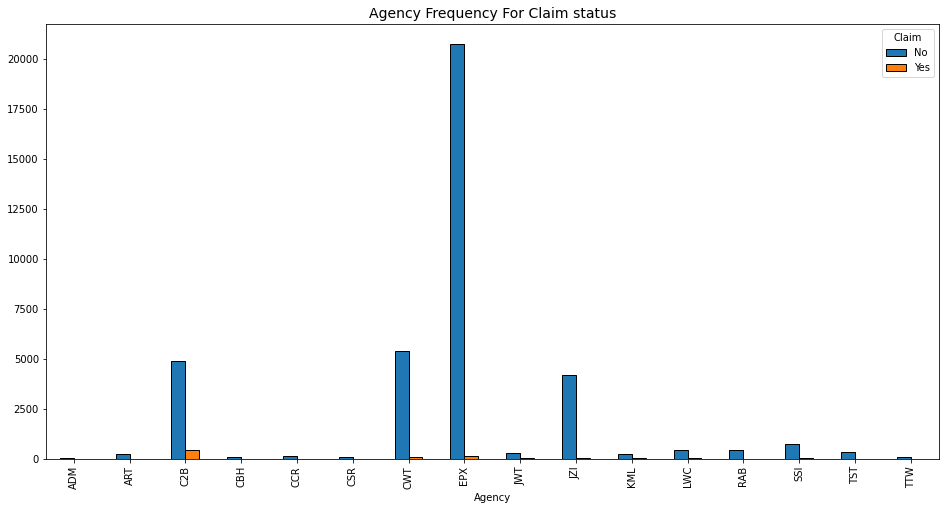

In [669]:
pd.crosstab(df_new['Agency'], df_new['Claim']).plot(kind = 'bar', figsize = (16, 8), rot= 90, ec= 'black')
plt.title('Agency Frequency For Claim status', fontsize= 14)

plt.show()

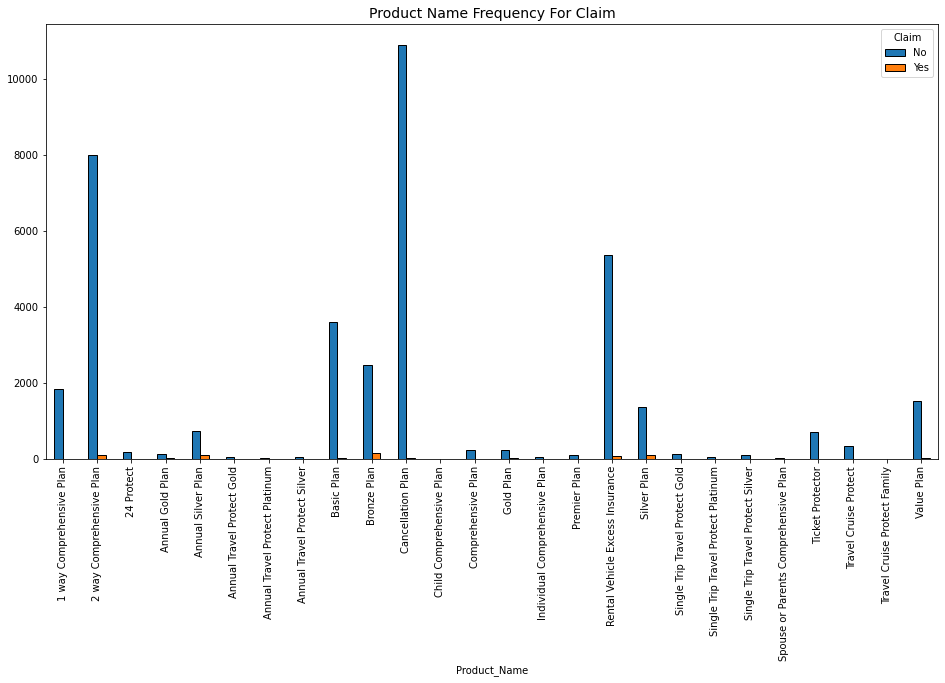

In [670]:
pd.crosstab(df_new['Product_Name'], df_new['Claim']).plot(kind= "bar", figsize= (16,8), rot= 90, ec= 'black')
plt.title('Product Name Frequency For Claim', fontsize= 14)
plt.show()

Visualisasi untuk data yang numerik

In [671]:
# Membuat kolom baru untuk data numerik

df_numerical = df_new._get_numeric_data()
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38816 entries, 0 to 44327
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Duration   38816 non-null  float64
 1   Net_Sales  38816 non-null  float64
 2   Commision  38816 non-null  float64
 3   Age        38816 non-null  float64
dtypes: float64(4)
memory usage: 1.5 MB


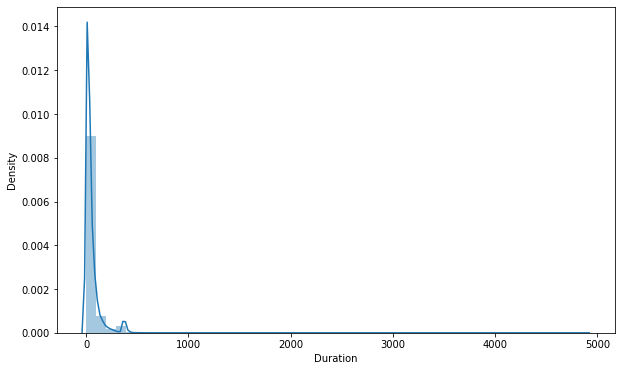

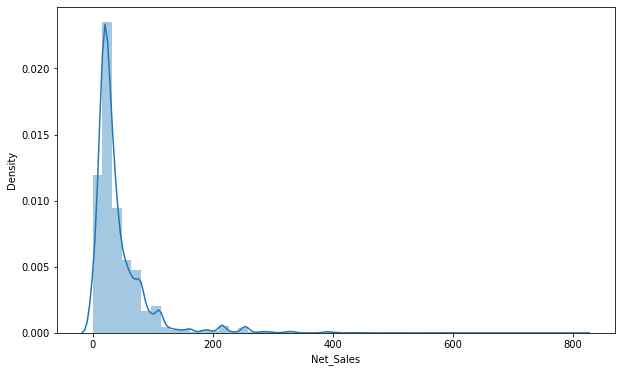

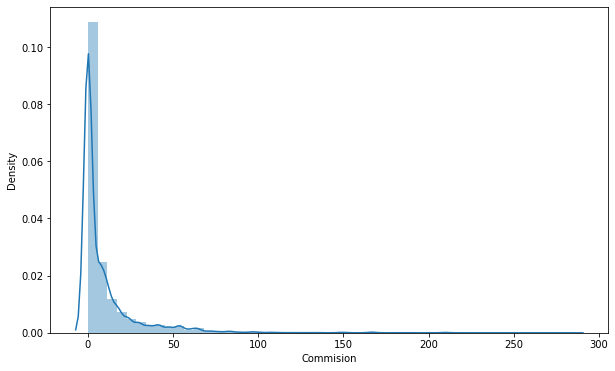

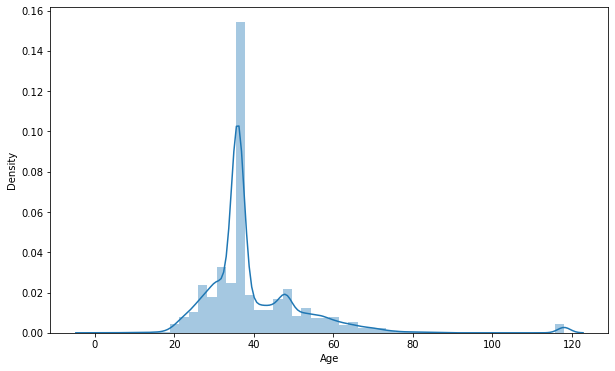

In [672]:
for i, col in enumerate(df_numerical.columns):
    plt.figure(figsize=(10,6))
    sns.distplot(df_numerical[col])


In [673]:
class ChiSquare:
    def __init__(self, df_new):
        self.df = df_new
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)
        
    def TestIndependence(self, colX, colY, alpha= 0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y, X) 
        chi2, p, dof, expected = ss.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)

In [674]:
X = df_new.drop(['Claim'], axis=1)
ct = ChiSquare(df_new)
for c in X.columns:
    ct.TestIndependence(c, 'Claim')

Agency is IMPORTANT for Prediction
Agency_Type is IMPORTANT for Prediction
Distribution_Channel is NOT an important predictor. (Discard Distribution_Channel from model)
Product_Name is IMPORTANT for Prediction
Duration is IMPORTANT for Prediction
Destination is IMPORTANT for Prediction
Net_Sales is IMPORTANT for Prediction
Commision is IMPORTANT for Prediction
Age is IMPORTANT for Prediction


In [675]:
df_new['Distribution_Channel'].unique()

array(['Online', 'Offline'], dtype=object)

In [676]:
df_new['Distribution_Channel'].value_counts()

Online     38109
Offline      707
Name: Distribution_Channel, dtype: int64

Dari informasi diatas diketahui bahwa data pada kolom `Distribution_Channel` tidak terlalu memberikan pengaruh sebagai dependent variable. Jadi data pada kolom ini dapat di-drop dan kita akan lakukan hal tersebut.

In [677]:
df_new.drop(columns= ['Distribution_Channel'], inplace= True)

In [678]:
df_new.columns

Index(['Agency', 'Agency_Type', 'Product_Name', 'Duration', 'Destination',
       'Net_Sales', 'Commision', 'Age', 'Claim'],
      dtype='object')

In [679]:
df_new.head()

,Agency,Agency_Type,Product_Name,Duration,Destination,Net_Sales,Commision,Age,Claim
0,C2B,Airlines,Annual Silver Plan,365.0,SINGAPORE,216.0,54.0,57.0,No
1,EPX,Travel Agency,Cancellation Plan,4.0,MALAYSIA,10.0,0.0,33.0,No
2,JZI,Airlines,Basic Plan,19.0,INDIA,22.0,7.7,26.0,No
3,EPX,Travel Agency,2 way Comprehensive Plan,20.0,UNITED STATES,112.0,0.0,59.0,No
4,C2B,Airlines,Bronze Plan,8.0,SINGAPORE,16.0,4.0,28.0,No


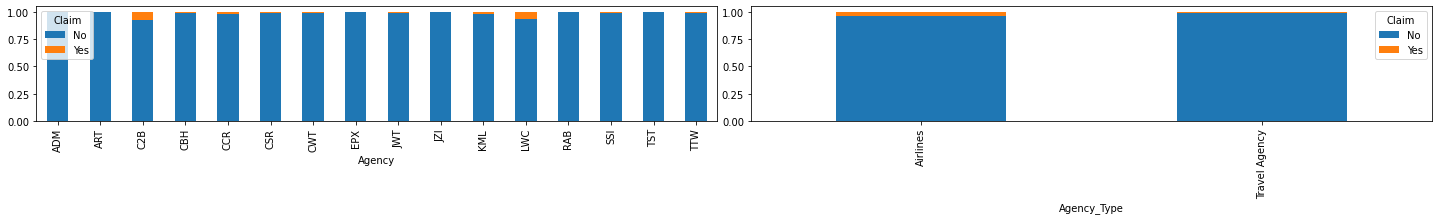

In [680]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df_new.drop(columns=['Claim','Duration','Commision', 'Product_Name', 'Net_Sales', 'Destination', 'Age']).columns:
    count +=1
    ax= plt.subplot(7, 2,count)
    pd.crosstab(df_new[i], df_new['Claim'],normalize=0).plot(kind='bar', stacked=True, ax=ax)
    fig.tight_layout()

plt.show()

In [681]:
df_new.describe()

,Duration,Net_Sales,Commision,Age
count,38816.000000,38816.00000,38816.000000,38816.000000
mean,51.986165,43.49916,9.560297,39.833290
std,113.780561,48.35249,19.738704,13.197319
min,0.000000,0.00000,0.000000,0.000000
25%,11.000000,19.80000,0.000000,35.000000
50%,25.000000,29.00000,0.000000,36.000000
75%,56.000000,50.00000,10.500000,44.000000
max,4881.000000,810.00000,283.500000,118.000000


##### Check outlier

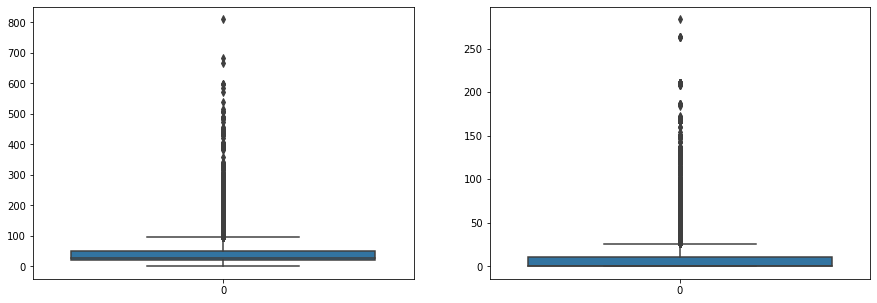

In [682]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data = df_new['Net_Sales'], ax=axes[0])
sns.boxplot(data = df_new['Commision'], ax=axes[1])

plt.show()

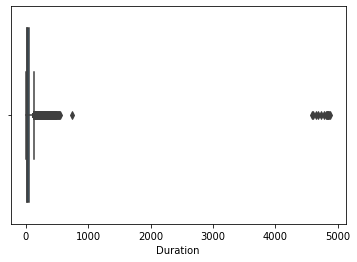

In [683]:
sns.boxplot(x= df_new['Duration'])
plt.show()

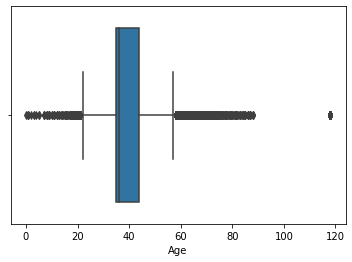

In [684]:
sns.boxplot(x= df_new['Age'])
plt.show()

Dari visualisasi diatas diketehui bahwa pada data numerik ditemukan data outlier.

In [685]:
df_new.dtypes

Agency           object
Agency_Type      object
Product_Name     object
Duration        float64
Destination      object
Net_Sales       float64
Commision       float64
Age             float64
Claim            object
dtype: object

**Check Imbalance**

Terjadi data imbalance, kita dapat handle dengan salah satu teknik yang ada:
- Ressampling (undersampling atau oversampling) -> SMOTE
- Algorithm -> Class_weight = balance

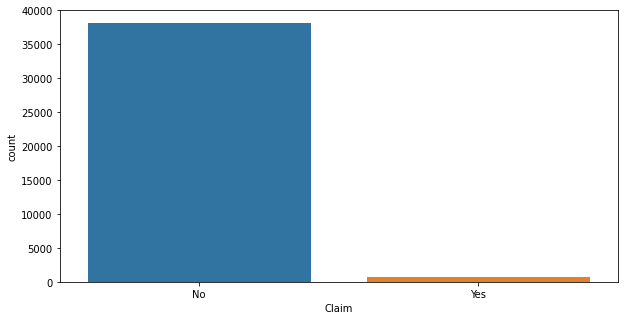

In [686]:
# Cek imbalance pada kolom Claim

plt.figure(figsize = (10, 5))
sns.countplot(df_new['Claim'])
plt.show()

In [687]:
df_new.head()

,Agency,Agency_Type,Product_Name,Duration,Destination,Net_Sales,Commision,Age,Claim
0,C2B,Airlines,Annual Silver Plan,365.0,SINGAPORE,216.0,54.0,57.0,No
1,EPX,Travel Agency,Cancellation Plan,4.0,MALAYSIA,10.0,0.0,33.0,No
2,JZI,Airlines,Basic Plan,19.0,INDIA,22.0,7.7,26.0,No
3,EPX,Travel Agency,2 way Comprehensive Plan,20.0,UNITED STATES,112.0,0.0,59.0,No
4,C2B,Airlines,Bronze Plan,8.0,SINGAPORE,16.0,4.0,28.0,No


Berikut informasi yang ditemukan setelah proses analisa data:

Dari hasil analisis diatas diketahui bahwa banyak missing value pada kolom `Gender`, ini kemungkinan terjadi karena customer tidak mengisi data tersebut. Oleh karena itu kita drop kolom tersebut mengingat kurang memungkinkan jika kita mengisi data tersebut dengan nilai mean, median, ataupun modus. Selain itu kolom tersebut juga kurang memiliki pengaruh penting untuk analisa data.

Kolom `Distribution_Channel` juga kita drop dikarenakan tidak memberikan pengaruh sebagai dependent variable.

Kemudian untuk kolom `Net_Sales` dan `Commision`, ada beberapa data yang kurang sesuai atau tidak benar. Pertama, ada nilai negatif pada kolom `Net_Sales`. Data ini seharusnya tidak mungkin dan kita sudah handle dengan drop data tersebut. Kedua, ditemukan juga nilai pada kolom `Commision` lebih besar dari `Net_Sales`. Hal ini juga tidak mungkin dan seharusnya tidak terjadi. Kita handle dengan cara mengubah nilai `Commision` menjadi nol atau tidak ada komisi yang didapat.

Pada kolom `Duration` ditemukan data bernilai negatif (-1) sebanyak 2 data. Setelah dilakukan perbandingan dan pengecekan lebih lanjut, kita mengubah nilai pada data tersebut menjadi positif 1.

Selain itu, ada imbalance data pada data `Claim` yang nantinya akan dijadikan target. Kita harus handle kendala ini agar nantinya model yang dihasilkan baik.

## Data Preparation and Feature Engineering

In [688]:
# Data yang sudah bersih

listItem = []
for col in df_new.columns :
    listItem.append([col, df_new[col].dtype, df_new[col].isna().sum(), round((df_new[col].isna().sum()/len(df_new[col])) * 100,2),
                    df_new[col].nunique(), list(df_new[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Agency,object,0,0.0,16,"[ART, SSI]"
1,Agency_Type,object,0,0.0,2,"[Travel Agency, Airlines]"
2,Product_Name,object,0,0.0,26,"[Premier Plan, Single Trip Travel Protect Gold]"
3,Duration,float64,0,0.0,435,"[457.0, 342.0]"
4,Destination,object,0,0.0,137,"[LEBANON, TAJIKISTAN]"
5,Net_Sales,float64,0,0.0,886,"[152.0, 272.3]"
6,Commision,float64,0,0.0,905,"[3.74, 11.11]"
7,Age,float64,0,0.0,89,"[21.0, 46.0]"
8,Claim,object,0,0.0,2,"[Yes, No]"


In [689]:
df_new.head()

,Agency,Agency_Type,Product_Name,Duration,Destination,Net_Sales,Commision,Age,Claim
0,C2B,Airlines,Annual Silver Plan,365.0,SINGAPORE,216.0,54.0,57.0,No
1,EPX,Travel Agency,Cancellation Plan,4.0,MALAYSIA,10.0,0.0,33.0,No
2,JZI,Airlines,Basic Plan,19.0,INDIA,22.0,7.7,26.0,No
3,EPX,Travel Agency,2 way Comprehensive Plan,20.0,UNITED STATES,112.0,0.0,59.0,No
4,C2B,Airlines,Bronze Plan,8.0,SINGAPORE,16.0,4.0,28.0,No


### Feature Engineering

Dalam tahap feature engineering kita akan melakukan proses encoding dan scaling.

Pertama, kita akan melakukan encoding untuk data categorical pada kolom `Agency`, `Agency_Type`, `Product_Name`, `Destination`, dan `Claim`. Teknik encoding yang kita lakukan adalah dengan **Label Encoding (LabelEncoder)**. <br>
Teknik ini diterapkan untuk mengubah data categorical menjadi data numerik agar dapat dibaca oleh Machine Learning. Referensi dapat dilihat pada link dibawah:

- https://www.geeksforgeeks.org/ml-label-encoding-of-datasets-in-python/
- https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
- https://www.javatpoint.com/label-encoding-in-python
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html


Kedua, kita akan melakukan proses scaling (MinMaxScaler) pada data numerik karena ditemukan outlier. Scaling akan dilakukan pada data `Duration`, `Net_Sales`, `Commision`, dan `Age`.

In [690]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38816 entries, 0 to 44327
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Agency        38816 non-null  object 
 1   Agency_Type   38816 non-null  object 
 2   Product_Name  38816 non-null  object 
 3   Duration      38816 non-null  float64
 4   Destination   38816 non-null  object 
 5   Net_Sales     38816 non-null  float64
 6   Commision     38816 non-null  float64
 7   Age           38816 non-null  float64
 8   Claim         38816 non-null  object 
dtypes: float64(4), object(5)
memory usage: 4.0+ MB


**Label Encoding**

In [691]:
df_new.select_dtypes('O').columns

Index(['Agency', 'Agency_Type', 'Product_Name', 'Destination', 'Claim'], dtype='object')

In [692]:
label_encoder1 = LabelEncoder()
df_new['Agency']= label_encoder1.fit_transform(df_new['Agency'])
  
label_encoder2 = LabelEncoder()
df_new['Agency_Type']= label_encoder2.fit_transform(df_new['Agency_Type'])

label_encoder3 = LabelEncoder()
df_new['Product_Name']= label_encoder3.fit_transform(df_new['Product_Name'])

label_encoder4 = LabelEncoder()
df_new['Claim']= label_encoder4.fit_transform(df_new['Claim'])

label_encoder5 = LabelEncoder()
df_new['Destination']= label_encoder5.fit_transform(df_new['Destination'])

In [693]:
df_new['Claim'].value_counts()

0    38143
1      673
Name: Claim, dtype: int64

In [694]:
# Data yang sudah di encoding

df_new.head()

,Agency,Agency_Type,Product_Name,Duration,Destination,Net_Sales,Commision,Age,Claim
0,2,0,4,365.0,109,216.0,54.0,57.0,0
1,7,1,10,4.0,73,10.0,0.0,33.0,0
2,9,0,8,19.0,52,22.0,7.7,26.0,0
3,7,1,1,20.0,129,112.0,0.0,59.0,0
4,2,0,9,8.0,109,16.0,4.0,28.0,0


In [695]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38816 entries, 0 to 44327
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Agency        38816 non-null  int32  
 1   Agency_Type   38816 non-null  int32  
 2   Product_Name  38816 non-null  int32  
 3   Duration      38816 non-null  float64
 4   Destination   38816 non-null  int32  
 5   Net_Sales     38816 non-null  float64
 6   Commision     38816 non-null  float64
 7   Age           38816 non-null  float64
 8   Claim         38816 non-null  int32  
dtypes: float64(4), int32(5)
memory usage: 3.2 MB


**Define features dan target**

Target (y) dalam dataset ini yaitu data pada kolom Claim. Sedangkan features (X) adalah data pada semua kolom kecuali Claim dan Gender (sudah di drop pada proses sebelumnya)

In [696]:
x = df_new.drop(columns= ['Claim']) # features
y = df_new['Claim'] # target

In [697]:
print(x.shape)
print(y.shape)

(38816, 8)
(38816,)


**Imbalanced data**

Berdasarkan pengecekan sebelumnya bahwa ada imbalance data pada kolom Claim (yang akan dijadikan target). Oleh karena itu kita akan handle imbalance tersebut dengan teknik oversampling. Teknik oversampling yaitu dengan membangkitkan sejumlah data baru yang mirip dengan data kelas minoritas.
Kita tidak hanya menduplikasi tapi membuat data tiruan yang serupa dengan kelas minoritas. <br>
Teknik yang diterapkan adalah Synthetic Minority Oversampling Technique (**SMOTE**). Dalam teknik ini kita akan terus menammbah data pada kelas minoritas hingga distribusinya lebih berimbah. <br>
Reference:
- https://towardsdatascience.com/applying-smote-for-class-imbalance-with-just-a-few-lines-of-code-python-cdf603e58688
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
- https://www.kite.com/blog/python/smote-python-imbalanced-learn-for-oversampling/
- https://medium.com/codex/how-to-use-smote-to-detect-fraud-in-python-7c5d9988da6

In [698]:
# Menerapkan SMOTE dan cek data setelahnya

sm = SMOTE(random_state= 42)
x_sm, y_sm = sm.fit_resample(x, y)

print(f'''Shape of X before SMOTE: {x.shape}
Shape of X after SMOTE: {x_sm.shape}''')

print('\nBalance of positive and negative classes (%): ')
y_sm.value_counts(normalize= True)*100

Shape of X before SMOTE: (38816, 8)
Shape of X after SMOTE: (76286, 8)

Balance of positive and negative classes (%): 


0    50.0
1    50.0
Name: Claim, dtype: float64

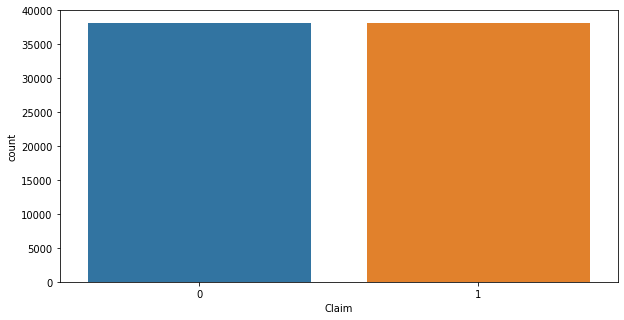

In [699]:
# visualisasi after proses SMOTE

plt.figure(figsize = (10, 5))
sns.countplot(y_sm)
plt.show()

**Scaling**

Pada tahap ini, kita akan scaling data yang sudah imbang atau tidak ada imbalance data agar dapat menemukan hasil yang baik.

In [700]:
x_new_df = pd.DataFrame()
to_scale = x_sm.columns
mms = MinMaxScaler()
x_new_df[to_scale] = mms.fit_transform(x_sm[to_scale])
x_new_df.head()

,Agency,Agency_Type,Product_Name,Duration,Destination,Net_Sales,Commision,Age
0,0.133333,0.0,0.16,0.074780,0.801471,0.266667,0.190476,0.483051
1,0.466667,1.0,0.40,0.000820,0.536765,0.012346,0.000000,0.279661
2,0.600000,0.0,0.32,0.003893,0.382353,0.027160,0.027160,0.220339
3,0.466667,1.0,0.04,0.004098,0.948529,0.138272,0.000000,0.500000
4,0.133333,0.0,0.36,0.001639,0.801471,0.019753,0.014109,0.237288


**Splitting**

Kita akan split data dengan test_size 0.3.

In [701]:
# Splitting dengan menggunakan data yang sudah di SMOTE

X_train, X_test, y_train, y_test = train_test_split(x_new_df, y_sm,
                                                    test_size= 0.3,
                                                    random_state= 42,
                                                    stratify= y_sm)

In [702]:
print("Data Train: ", X_train.shape, " ", y_train.shape)
print("Data Test : ", X_test.shape, " ", y_test.shape)

Data Train:  (53400, 8)   (53400,)
Data Test :  (22886, 8)   (22886,)


## Model Building and Evaluation

### Build Model

Pemodelan yang akan dicoba adalah sbb:
- Logistic Regression
- Random Forest
- Decision Tree
- KNN
- XGBoost


##### Logistic Regression

In [703]:
# 1. Logistic Regression

logreg = LogisticRegression(random_state=42, max_iter=200)
logreg.fit(X_train, y_train)
pred_test = logreg.predict(X_test)
pred_train = logreg.predict(X_train)

print("Train Accuracy Balanced Data",np.mean(y_train == pred_train))
print("Test Accuracy Balanced Data",np.mean(y_test == pred_test))

print(classification_report(y_test, pred_test))

Train Accuracy Balanced Data 0.7796816479400749
Test Accuracy Balanced Data 0.779122607707769
              precision    recall  f1-score   support

           0       0.75      0.84      0.79     11443
           1       0.81      0.72      0.77     11443

    accuracy                           0.78     22886
   macro avg       0.78      0.78      0.78     22886
weighted avg       0.78      0.78      0.78     22886



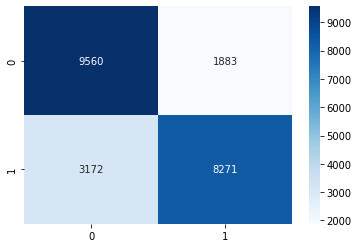

In [704]:
cm = confusion_matrix(y_test, pred_test)
# let's visualize cm2
sns.heatmap(cm,cmap= "Blues",annot = True, fmt='')
plt.show()

Area under the ROC curve : 0.779123


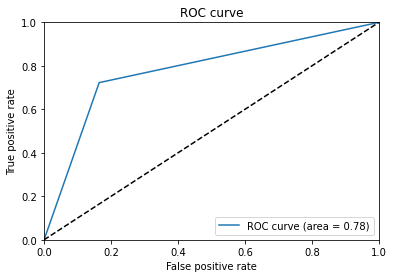

In [705]:
# Compute ROC curve area under the curve
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc = auc(fpr,tpr) 
print("Area under the ROC curve : %f" % roc_auc)

# Plot ROC curve
plt.clf
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

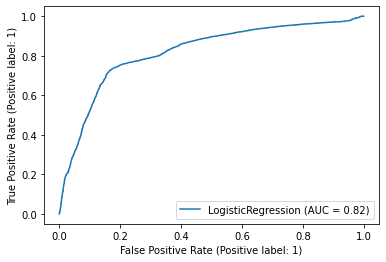

In [706]:
plot_roc_curve(logreg, X_test, y_test)
plt.show()

##### Random Forest

In [707]:
# 2. Random Forest

rf = RandomForestClassifier(criterion= 'gini', random_state=42)
rf.fit(X_train, y_train)
pred_test = rf.predict(X_test)
pred_train = rf.predict(X_train)

print("Train Accuracy Balanced Data",np.mean(y_train == pred_train))
print("Test Accuracy Balanced Data",np.mean(y_test == pred_test))

print(classification_report(y_test, pred_test))

Train Accuracy Balanced Data 0.9993071161048689
Test Accuracy Balanced Data 0.9738704885082583
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     11443
           1       0.97      0.98      0.97     11443

    accuracy                           0.97     22886
   macro avg       0.97      0.97      0.97     22886
weighted avg       0.97      0.97      0.97     22886



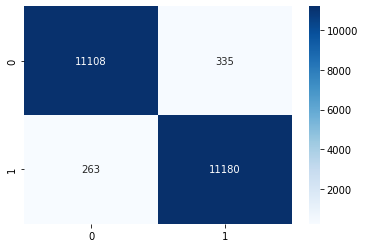

In [708]:
cm2 = confusion_matrix(y_test, pred_test)
# let's visualize cm2
sns.heatmap(cm2,cmap= "Blues",annot = True, fmt='')
plt.show()

Area under the ROC curve : 0.973870


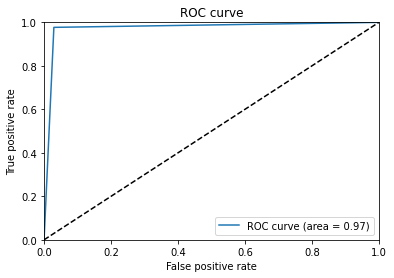

In [709]:
## Let's plot ROC(Receiver Operating Characteristics) curve :
# Compute ROC curve area under the curve
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc = auc(fpr,tpr) 
print("Area under the ROC curve : %f" % roc_auc)

# Plot ROC curve
plt.clf
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

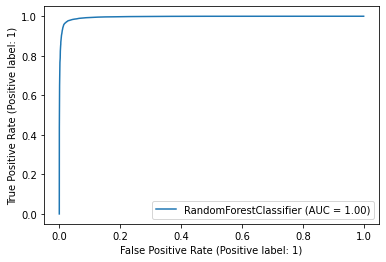

In [710]:
plot_roc_curve(rf, X_test, y_test)
plt.show()

##### Decision Tree

In [711]:
dt = DecisionTreeClassifier(random_state=42, splitter='best', min_samples_split=4, min_samples_leaf=2)
dt.fit(X_train,y_train)
pred_test = dt.predict(X_test)
pred_train = dt.predict(X_train)

print("Train Accuracy Balanced Data",np.mean(y_train == pred_train))
print("Test Accuracy Balanced Data",np.mean(y_test == pred_test))

print(classification_report(y_test,pred_test))

Train Accuracy Balanced Data 0.9877153558052435
Test Accuracy Balanced Data 0.9544699816481692
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     11443
           1       0.96      0.95      0.95     11443

    accuracy                           0.95     22886
   macro avg       0.95      0.95      0.95     22886
weighted avg       0.95      0.95      0.95     22886



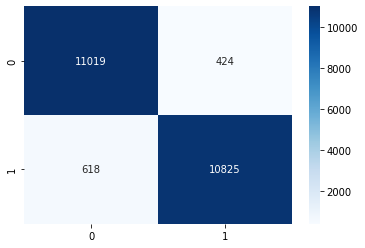

In [712]:
cm3 = confusion_matrix(y_test, pred_test)
# let's visualize cm
sns.heatmap(cm3,cmap= "Blues",annot = True, fmt='')
plt.show()

Area under the ROC curve : 0.954470


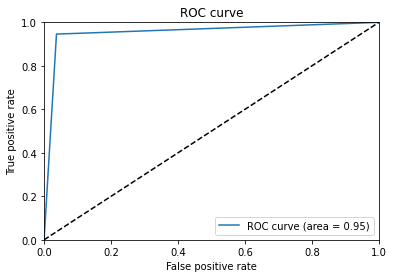

In [713]:
## Let's plot ROC(Receiver Operating Characteristics) curve :
# Compute ROC curve area under the curve
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc = auc(fpr,tpr) 
print("Area under the ROC curve : %f" % roc_auc)

# Plot ROC curve
plt.clf
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

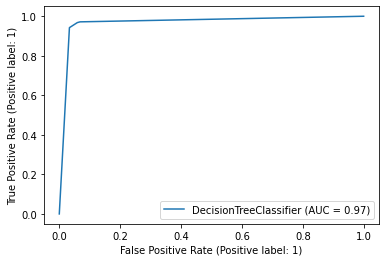

In [714]:
plot_roc_curve(dt, X_test, y_test)
plt.show()

##### KNN

In [715]:
# 4. KNN

knn = KNeighborsClassifier(n_neighbors= 5, n_jobs=200)
knn.fit(X_train, y_train)
pred_test = knn.predict(X_test)
pred_train = knn.predict(X_train)

print("Train Accuracy Balanced Data",np.mean(y_train == pred_train))
print("Test Accuracy Balanced Data",np.mean(y_test == pred_test))

print(classification_report(y_test, pred_test))

Train Accuracy Balanced Data 0.9442134831460675
Test Accuracy Balanced Data 0.9157563575985318
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     11443
           1       0.88      0.96      0.92     11443

    accuracy                           0.92     22886
   macro avg       0.92      0.92      0.92     22886
weighted avg       0.92      0.92      0.92     22886



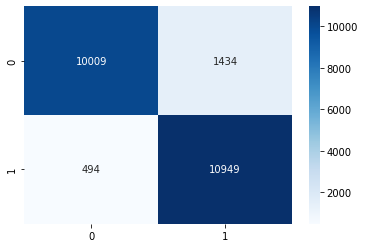

In [716]:
cm4 = confusion_matrix(y_test, pred_test)
# let's visualize cm
sns.heatmap(cm4,cmap= "Blues",annot = True, fmt='')
plt.show()

Area under the ROC curve : 0.915756


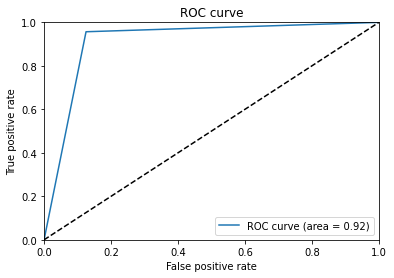

In [717]:
# Compute ROC curve area under the curve
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc = auc(fpr,tpr) 
print("Area under the ROC curve : %f" % roc_auc)

# Plot ROC curve
plt.clf
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

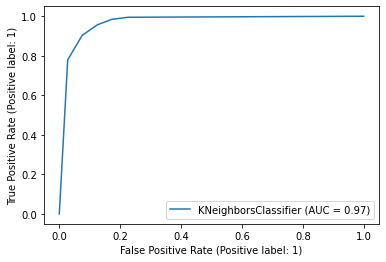

In [718]:
plot_roc_curve(knn, X_test, y_test)
plt.show()

##### XGBoost

In [719]:
# 5. XGBoost (eXtreme Gradient Boosting)

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
pred_test = xgb.predict(X_test)
pred_train = xgb.predict(X_train)

print("Train Accuracy Balanced Data",np.mean(y_train == pred_train))
print("Test Accuracy Balanced Data",np.mean(y_test == pred_test))

print(classification_report(y_test, pred_test))

Train Accuracy Balanced Data 0.98125468164794
Test Accuracy Balanced Data 0.974307436860963
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     11443
           1       0.98      0.97      0.97     11443

    accuracy                           0.97     22886
   macro avg       0.97      0.97      0.97     22886
weighted avg       0.97      0.97      0.97     22886



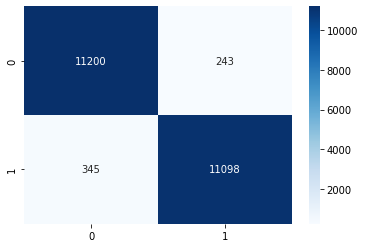

In [720]:
# Making the Confusion Matrix
cm5 = confusion_matrix(y_test, pred_test)

# let's visualize cm
sns.heatmap(cm5,cmap= "Blues",annot = True, fmt='')
plt.show()

Area under the ROC curve : 0.974307


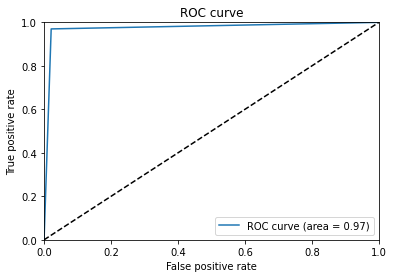

In [721]:
## Let's plot ROC(Receiver Operating Characteristics) curve :

# Compute ROC curve area under the curve
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc = auc(fpr,tpr) 
print("Area under the ROC curve : %f" % roc_auc)

# Plot ROC curve
plt.clf
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

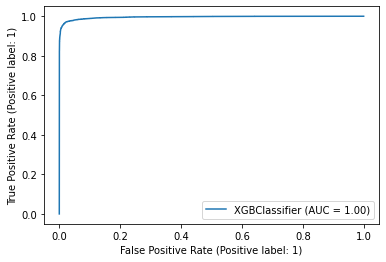

In [722]:
plot_roc_curve(xgb, X_test, y_test)
plt.show()

Dari pengecekan diatas didapat bahwa, teknik oversampling dapat meningkatkan nilai recall menjadi rata-rat atau diatas 90%.
Model terbaiknya adalah XGBoosting dengan hasil accuracy 97%.

### Saving model 

In [723]:
import pickle
pickle.dump(xgb, open('Travel_Claims_model.pkl','wb'))

## Conclusion and Recomendation

In [724]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
pred_test = xgb.predict(X_test)
pred_train = xgb.predict(X_train)

print("Train Accuracy Balanced Data",np.mean(y_train == pred_train))
print("Test Accuracy Balanced Data",np.mean(y_test == pred_test))

print(classification_report(y_test, pred_test))

Train Accuracy Balanced Data 0.98125468164794
Test Accuracy Balanced Data 0.974307436860963
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     11443
           1       0.98      0.97      0.97     11443

    accuracy                           0.97     22886
   macro avg       0.97      0.97      0.97     22886
weighted avg       0.97      0.97      0.97     22886



**Conclusion**

Berdasarkan hasil analisa yang telah dilakukan dari model kita, kita dapat menyimpulkan bahwa bila seandainya kita menggunakan model kita untuk menyaring kandidat customer Claim asuransi yang ada. Model ini dapat mengurangi 98% kandidat customer yang tidak berhak menerima claim dan mendapatkan 97% kandidat customer yang seharusnya mendapatkan claim. Nilai ini berdasarkan recall pada model yang kita buat.

Jika dilihat dari precisionnya, maka kita dapat memprediksi kandidat yang berhak mendapatkan Claim sebesar 98%. Jadi kemungkinan model melakukan prediksi yang benar untuk kandidat yang mendapatkan Claim sebesar 98%. Nilai ini cukup tinggi, oleh karena itu model dapat dikatakan sebagai model terbaik.


**Recomendation**

Berikut hal yang dapat dilakukan untuk mengembangkan project dan modelnya:
- Perusahaan membuat kebijakan agar customer dapat mengisi data dengan benar dan sesuai sepperti pada data `Gender`, `Commision`, `Net Sales`, `Age`, dan `Duration`.
- Menambahkan fitur atau kolom baru yang berkaitan agar menghindari imbalance data dan data lebih bervariasi.
